# 🔍 Model Evaluation Notebook
用于加载已训练好的模型 `.pth` 文件，对验证集进行准确率评估与混淆矩阵分析。

In [16]:
# Step 1: required library
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [17]:
# Step 2: define preprocessing and load TrashNet
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root='../datasets/trashnet', transform=transform)
class_names = full_dataset.classes

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
_, val_dataset = random_split(full_dataset, [train_size, val_size])
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
# Step 3: load parameters of models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 6)
model.load_state_dict(torch.load('../models/recycling_resnet18_15ep.pth', map_location=device))
model = model.to(device)

In [19]:
# Step 4: define evaluation function
def evaluate(model, val_loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = correct / total
    print(f"\n Accuracy of Validation Set: {acc:.4f}")

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))


 Accuracy of Validation Set: 0.8874


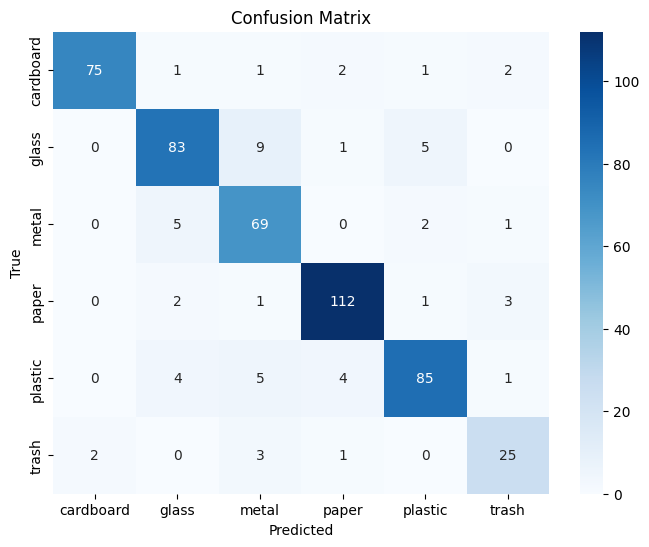


📊 Classification Report:
              precision    recall  f1-score   support

   cardboard       0.97      0.91      0.94        82
       glass       0.87      0.85      0.86        98
       metal       0.78      0.90      0.84        77
       paper       0.93      0.94      0.94       119
     plastic       0.90      0.86      0.88        99
       trash       0.78      0.81      0.79        31

    accuracy                           0.89       506
   macro avg       0.88      0.88      0.88       506
weighted avg       0.89      0.89      0.89       506



In [20]:
# Step 5: evaluation
evaluate(model, val_loader, class_names)